In [196]:
# Initialize Otter
import otter
grader = otter.Notebook("Project2.ipynb")

In [197]:
rng_seed = 42

# Project 2: 
## Neural Networks, Finite Differences

## Problem 1: Neural Network from Scratch using Numpy

Unfortunately, DataHub does not have GPUs for hard machine learning tasks. In this project, we will instead focus on going back to the basics: Writing out a neural network using numpy.

### Problem Goals:
    
The goal of this problem is to understand the logic behind neural networks, including the weights, activation, the optimization algorithm (Stochastic Gradient Descent) and especially backpropagation. These are all topics that have been covered in the course so far, and I would recommend you go back through the course notes and material for each.

In this project, you will **implement a feed-forward neural network (multi-layer perceptron)** entirely from scratch using **NumPy only** — no deep learning libraries such as PyTorch, TensorFlow, or JAX. You will apply your network to a **real dataset** from scikit-learn (`load_digits`), train it to classify handwritten digits (0–9), and compare your results to scikit-learn's `MLPClassifier`.

### Data:

We will use **`sklearn.datasets.load_digits()`** (think of it as a lighter version of MNIST), with the goal of writing our own classifier to classify this data. 

This dataset contains **1797 images**, each an 8×8 grayscale pixel grid (64 features), labeled with an integer digit (0–9). No preprocessing beyond standardization is needed — the features are already numeric.

## What you submit
See below for the separate parts of the problem. In summary,  you will be submittin a `.ipynb` in a PDF file with:

1. **Working implementation** of an MLP classifier (your own code using NumPy only).
2. **Training logs/plots** for loss/accuracy on train and validation.
3. **Final metrics** on a held‑out test set.
4. **Baseline comparison** vs ``sklearn.neural_networl.MLPClassifier`.
5. **Short write‑up (≤300 words)**: design choices, what worked/didn’t, any regularization tricks.

### Submission
Submit via Gradescope by uploading a `.pdf` file. Before submitting, you should restart and run your notebook from top-to-bottom, without any errors. You can use Cmd + P to generate the submission PDF within DataHub.

### Rules and Hints
- You may use `numpy`, `matplotlib`, and `sklearn` (for data utilities and baseline only).
- No `torch`, `tensorflow`, `jax`, or external neural network libraries.
- Numerical stability matters! Always use `log(np.clip(...))` in loss computations (see below).
- Use vectorized NumPy operations (avoid Python loops in your core model).
- Comment your code and make it clear what each step does.
- Your code must be your own.
- **You may use material on the [Course Github](https://github.com/MarkusHohle/UC-Berkeley/tree/main/Phys-188_288/Fall%202025/10%20SGD%20ANN%20and%20basic%20Architecture/Codes) to help you write the code.**

### Extra Background information: Softmax and Categorical Cross-Entropy Loss

As we are now considering a multi-category classification task, we should re-visit the methods used for multi-class classification. Specifically, the activation function Softmax and Categorical Cross-Entropy Loss.

#### **Softmax: Turning outputs into probabilities**

The final layer of your MLP produces **logits** — real-valued scores, one for each class.
Let the logits for a single example be  
$$ \mathbf{z} = (z_1, z_2, \ldots, z_C)$$
where $C$ is the number of classes (here $C = 10$).

The **softmax function** converts these logits into a probability distribution:
$$\text{softmax}(z_i) = p_i = \frac{e^{z_i}}{\sum_{j=1}^{C} e^{z_j}}$$
Each $p_i$ satisfies $0 \le p_i \le 1$ and $\sum_i p_i = 1$.

However, it is important to note that exponentials can overflow for large logit values. To avoid this, subtract the largest logit before exponentiating (it does not change the result):
$$ p_i = \frac{e^{z_i - z_{\max}}}{\sum_j e^{z_j - z_{\max}}}$$
where $z_{\max} = \max_j z_j$. This is the **stable softmax** implementation you will use.

#### **Categorical Cross-Entropy Loss**

Once we have predicted probabilities $p_i$, we want the loss to be **small** when the model assigns high probability to the true class.

If the true label is represented as a one-hot vector (a vector of length $C$ for $C$ classes, with:
$$ \mathbf{y} = (y_1, \ldots, y_C)
\quad\text{where } y_k = 
\begin{cases}
1 & \text{if class } k \text{ is correct}\\
0 & \text{otherwise}
\end{cases}
$$
then the **cross-entropy loss** for one example is:
$$
\mathcal{L} = -\sum_{i=1}^{C} y_i \, \log(p_i)
$$
Since only one $y_i$ equals 1, this simplifies to:
$$
\mathcal{L} = -\log(p_{\text{true class}})
$$
The average loss over all $N$ samples in a batch is:
$$
J = -\frac{1}{N} \sum_{n=1}^{N} \log p^{(n)}_{\text{true class}}
$$
Conceptually, **cross-entropy** measures how far the predicted probability distribution $p$ is from the true one-hot distribution $y$. Minimizing cross-entropy encourages $(p_{\text{true}}\to 1)$ and others $(\to 0)$.
                 
**To implement cross-entropy loss numerically**, we must implement a cutoff on $p$ to avoid $\log(0)$. You can use `np.log(np.clip(p, 1e-12, 1.0))` to achieve this.

In the backpropagation step, the combination of softmax and cross-entropy produces a particularly simple and elegant gradient:
$$
\frac{\partial \mathcal{L}}{\partial z_i} = p_i - y_i
$$


In [198]:
# Setup: imports, reproducibility, plotting defaults
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.utils import shuffle

np.set_printoptions(precision=4, suppress=True)
rng = np.random.default_rng(42)  # reproducible

<!-- BEGIN QUESTION -->

#### Part 1 — Setup and Data Handling 
1. Load, inspect and visualize the dataset (`load_digits`). (This is done for you)
2. Split into **train/validation/test** sets (≈70% / 15% / 15%).
3. Standardize features using `StandardScaler`.

X shape: (1797, 64), y shape: (1797,), classes: [0 1 2 3 4 5 6 7 8 9]


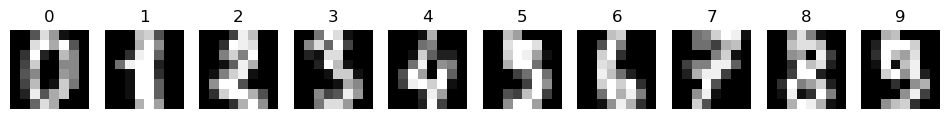

In [199]:
# Load and inspect the digits dataset
digits = load_digits()
X = digits.data.astype(np.float64)   # shape: (n_samples, 64)
y = digits.target.astype(np.int64)   # shape: (n_samples,)

print(f"X shape: {X.shape}, y shape: {y.shape}, classes: {np.unique(y)}")

# Visual sanity check
fig, axes = plt.subplots(1, 10, figsize=(12, 2.5))
for ax, i in zip(axes, range(10)):
    ax.imshow(digits.images[i], cmap='gray')
    ax.set_title(str(y[i]))
    ax.axis('off')
plt.show()

In [200]:
# Split and scale the data
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.7)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, train_size = 0.5)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

#### Part 2 — Build a Multi-Layer Perceptron (MLP)
Implement your own MLP class in NumPy. Make sure your class supports:
- Arbitrary number of neurons (e.g., `[64, 128, 64, 10]`, here 64 is the input dimension, and 10 is the output dimension).
- Activation functions: ReLU, Tanh, or Sigmoid. (Hint: You should define helper functions for these activations as well as their analytic gradients for backpropagation)
- Forward propagation and softmax output.
- Cross-entropy loss.
- Backpropagation for weight and bias gradients.
- Random weight initialization. (Typically random normal distributions. E.g. look into the He or Xavier initializations.)
- Optional: L2 regularization (`λ` parameter).

Important Notes:
- No autograd or deep learning libraries allowed.
- All derivatives must be implemented using NumPy operations.

A skeleton code design template for your MLP class is provided below. You do not have to follow it.

Some design notes for your MLP class, you do not have to follow it.

Write the following core methods:

- `__init__`: set up network architecture (layer sizes, activations, weight initialization, etc.).
- `forward`: perform one full forward pass through all layers and return the final logits.
- `loss_and_grads`: compute the loss (cross-entropy) and gradients of all parameters using backpropagation.
- `backward`: perform the backward pass with backpropagation. This could be integrated with the above.
- `predict`: use a forward pass to output the most likely class labels.

You may store intermediate quantities (e.g. activations and pre-activations) in a cache during the forward pass to reuse during backpropagation.

Try to **vectorize operations** using NumPy instead of writing loops over samples.  
Make sure you test each component (forward shapes, loss computation, gradient correctness) step by step before combining everything.

In [203]:
class myMLPClassifier: 
    import numpy as np 
    def __init__(self, layer_size = [64, 128, 64, 10], activation = 'relu', l2 = 0, momentum = 0):
        self.layer_size = layer_size
        self.activation = activation
        self.l2 = l2 
        self.momentum = momentum 

        ###### raise errors for argument mismatches ###########
        if not activation in ['relu', 'tanh', 'sigmoid']:
            raise ValueError("activation function must be either 'relu', 'tanh', or 'sigmoid'")
        ########################################################

        ##### initialize weights and bias matrices based on activation function ###########
        def Xavier(n,m): 
            lower, upper = -(1.0 / np.sqrt(n)), (1.0 / np.sqrt(n))
            numbers = np.random.rand(5000)
            scaled = lower + numbers * (upper - lower)
            weights = np.random.choice(scaled, n*m, replace = True)
            return weights.reshape(n,m)

        def He(n,m): 
            std = np.sqrt(2.0 / n)
            numbers = np.random.randn(1000)
            scaled = numbers * std
            weights = np.random.choice(scaled, n*m, replace = True)
            return weights.reshape(n,m) 
            
        if activation in ['sigmoid', 'tanh']:
            self.W = [Xavier(layer_size[i], layer_size[i+1]) for i in range(len(layer_size)-1)] # Xavier weight initialization
            self.b = [np.zeros((1, layer_size[i+1])) for i in range(len(layer_size)-1)] # zero initial bias 
        else: 
            self.W = [He(layer_size[i], layer_size[i+1]) for i in range(len(layer_size)-1)] # He weight initialization
            self.b = [np.zeros((1, layer_size[i+1])) for i in range(len(layer_size)-1)] # zero initial bias 
        ####################################################################################
        self.L = len(self.W)
        self.vW = [np.zeros_like(W) for W in self.W]
        self.vb = [np.zeros_like(b) for b in self.b]

    def forward(self, X):
        ##### define activation functions ################
        def relu(x):
            return np.maximum(0,x)
        def tanh(x):
            return np.tanh(x)
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))
        ##################################################
        L = self.L
        Z = X
        zs = [] # pre-activations
        hs = [X]
        
        # fully-forward propogation with relu activation 
        if self.activation == 'relu':
            for i in range(L):
                Z = Z @ self.W[i] + self.b[i]
                zs.append(Z)
                if i < L - 1:  
                    Z = relu(Z)
                hs.append(Z)
        if self.activation == 'tanh':
            for i in range(L):
                Z = Z @ self.W[i] + self.b[i]
                zs.append(Z)
                if i < L - 1:  
                    Z = tanh(Z)
                hs.append(Z)
        if self.activation == 'sigmoid':
            for i in range(L):
                Z = Z @ self.W[i] + self.b[i]
                zs.append(Z)
                if i < L - 1:  
                    Z = sigmoid(Z)
                hs.append(Z)
                
        def stable_softmax(Z):
            return [np.exp(Z[i] - np.max(Z[i])) / np.sum(np.exp(Z[i] - np.max(Z[i]))) for i in range(Z.shape[0])]

        return stable_softmax(Z), Z, zs, hs
        
    def loss_and_grads(self, X, Y):
        p, _, zs, hs = self.forward(X)
        p_true = [p[i][j] for i,j in enumerate(Y)]
        p_clip = np.clip(p_true, 1e-12, 1.0) # for numerical stability
        cross_entropy_loss = -np.mean(np.log(p_clip))
        
        ###### CE + L2 Regularization #########################################
        cross_entropy_loss = -np.mean(np.log(p_clip))
        l2reg_penalty = self.l2*np.sum([np.sum(self.W[i]**2) for i in range(len(self.W))])
        loss = cross_entropy_loss + l2reg_penalty
        #########################################################################
        grad_logits = p.copy()
        for i,j in enumerate(Y):
            grad_logits[i][j] -= 1
        
        return loss, grad_logits, zs, hs
        
    def backward(self,X,Y, learning_rate = 1e-3):
        ##### define activation function derivatives ######
        def d_relu(x):
            d = x.copy()
            for i in range(x.shape[0]):
                for j in range(x.shape[1]):
                    if x[i,j] < 0:
                        d[i,j] = 0
                    else:
                        d[i,j] = 1 
            return d
        def d_tanh(x):
            return (1/np.cosh(x))**2
        def d_sigmoid(x):
            return np.exp(-x) / (1 + np.exp(-x))**2
        ################################################### 
        L = self.L
        self.dW, self.db = [None]*(L), [None]*(L)
        _, delta, zs, hs = self.loss_and_grads(X,Y)
        
        for l in reversed(range(L)):
            self.dW[l] = hs[l].T @ delta 
            self.db[l] = np.sum(delta, axis=0, keepdims=True)
            
            if l != 0:
                if self.activation == 'relu':
                    delta = (delta @ self.W[l].T) * d_relu(zs[l-1]) 
                if self.activation == 'tanh':
                    delta = (delta @ self.W[l].T) * d_tanh(zs[l-1]) 
                if self.activation == 'sigmoid':
                    delta = (delta @ self.W[l].T) * d_sigmoid(zs[l-1]) 

        for l in range(L):
            self.vW[l] = self.momentum * self.vW[l] - learning_rate * (self.dW[l] + 2*self.l2 * self.W[l]) # l2 reg + momentum
            self.W[l] += self.vW[l]
 
            self.vb[l] = self.momentum * self.vb[l] - learning_rate * self.db[l] # momentum 
            self.b[l] += self.vb[l]
                
    def predict(self, X):
        Z = X 
        L = self.L
        for i in range(L):
            Z = Z @ self.W[i] + self.b[i]
            if i < L - 1:
                if self.activation == 'relu':
                    Z = np.maximum(0, Z)
                elif self.activation == 'tanh':
                    Z = np.tanh(Z)
                elif self.activation == 'sigmoid':
                    Z = 1/(1+np.exp(-Z))
            
        p = [np.exp(Z[i] - np.max(Z[i])) / np.sum(np.exp(Z[i] - np.max(Z[i]))) for i in range(Z.shape[0])]
        return np.argmax(p, axis=1)


In [204]:
m = myMLPClassifier([64, 128, 26, 10], activation = 'sigmoid')
# m.forward(X_train)[3]
# m.loss_and_grads(X_train, y_train)
m.backward(X_train, y_train) 
m.predict(X_train)
# np.argmax(m.p, axis = 1)
# m.W[2].shape
# m.W[2].shape

array([5, 5, 5, ..., 5, 5, 5], shape=(1257,))

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

#### Part 3 — Training Loop
Implement a training routine that:
- Uses **mini-batch SGD** (optionally with momentum).
- Tracks **training and validation loss/accuracy** over epochs.
- Includes an **optional learning-rate decay** parameter.
- Supports **early stopping** based on validation loss.

Plot the training curves (loss and accuracy vs. epoch).


Epoch 0:  Train Loss=0.3731, Train Acc=0.9165, Val Loss=0.4429, Val Acc=0.8963
Epoch 10:  Train Loss=0.0509, Train Acc=1.0000, Val Loss=0.1497, Val Acc=0.9667
Epoch 20:  Train Loss=0.0428, Train Acc=1.0000, Val Loss=0.1492, Val Acc=0.9667
Epoch 30:  Train Loss=0.0410, Train Acc=1.0000, Val Loss=0.1475, Val Acc=0.9704
Epoch 40:  Train Loss=0.0404, Train Acc=1.0000, Val Loss=0.1484, Val Acc=0.9667
Stopping early at epoch 40.


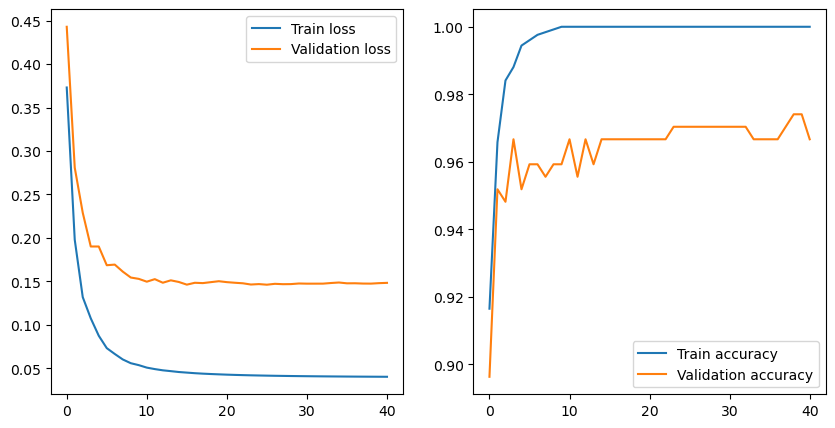

In [206]:
def train_MLP(model, X_train, y_train, X_val, y_val, 
              epochs = 500, patience = 15, lr = 1e-3, lr_decay = 0, 
              batch_size = 32, early_stopping = True):
    
    N = X_train.shape[0]   
    best_val_loss = np.inf
    counter = 0 # early stopping counter
    
    for epoch in range(epochs):
        perm = np.random.permutation(N)
        X_train, y_train = X_train[perm], y_train[perm]
           
        for start in range(0, N, batch_size):
            end = start + batch_size
            Xb = X_train[start:end]
            yb = y_train[start:end]
            model.backward(Xb, yb, lr) # forward, loss_grad, and backprop

        train_loss, _, _, _ = model.loss_and_grads(X_train, y_train)
        y_pred_train = model.predict(X_train)
        train_acc = np.mean(y_pred_train == y_train)

        val_loss, _, _, _ = model.loss_and_grads(X_val, y_val)
        y_pred_val = model.predict(X_val)
        val_acc = np.mean(y_pred_val == y_val)

        loss_train.append(train_loss)
        loss_val.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        ####### Report training and validation loss/accuracy every 10 epochs ########
        if epoch % 10 == 0:
            print(f"Epoch {epoch}:  "
                  f"Train Loss={train_loss:.4f}, "
                  f"Train Acc={train_acc:.4f}, "
                  f"Val Loss={val_loss:.4f}, "
                  f"Val Acc={val_acc:.4f}")
        #############################################################################
        
        ##### Early stopping based on validation loss ##########
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if early_stopping and patience_counter >= patience:
            print(f"Stopping early at epoch {epoch}.")
            break
        ########################################################
        
        lr = lr * (1.0 / (1.0 + lr_decay * epoch)) # update learning rate if decay_rate provided
        
           
loss_train = []
loss_val = [] 
train_accs = []
val_accs = [] 

m = myMLPClassifier(layer_size=[64, 128, 26, 10], activation = 'relu', l2 = 1e-4, momentum = 0.7)
train_MLP(m, X_train, y_train, X_val, y_val)

fig, ax = plt.subplots(1,2, figsize = (10,5))

ax[0].plot(loss_train, label = 'Train loss')
ax[0].plot(loss_val, label  = 'Validation loss')
ax[0].legend()

ax[1].plot(train_accs, label = 'Train accuracy')
ax[1].plot(val_accs, label  = 'Validation accuracy')
ax[1].legend()
plt.show()



<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

#### Part 4 — Evaluation
1. Evaluate the trained model on the **test set** and report:
   - Test accuracy.
   - Classification report (precision, recall, F1).
   - Confusion matrix (visualized as a heatmap).
2. Train a **baseline model** using `sklearn.neural_networl.MLPClassifier` and report the same metrics for comparison. 

   (If you want, you can use the `sgd` solver in `MLPClassifier` and the same layers/activation to replicate your model, though this is not necessary)

My MLP Test Acc = 0.9704
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        30
           1       1.00      1.00      1.00        23
           2       0.96      1.00      0.98        27
           3       1.00      1.00      1.00        26
           4       0.96      0.92      0.94        26
           5       0.96      0.96      0.96        24
           6       1.00      0.96      0.98        24
           7       0.94      0.97      0.96        33
           8       0.94      1.00      0.97        30
           9       0.96      0.93      0.94        27

    accuracy                           0.97       270
   macro avg       0.97      0.97      0.97       270
weighted avg       0.97      0.97      0.97       270

Sklearn MLP Test Acc = 0.8815
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        30
           1       0.63      0.83      0.72        23
           2       0.96

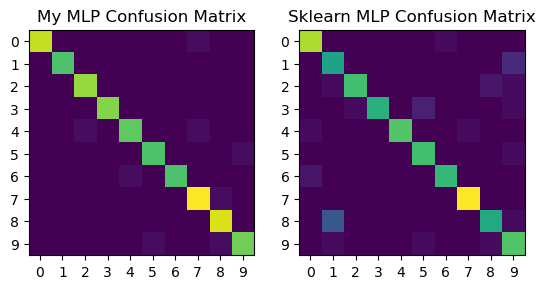

In [209]:
test_pred = m.predict(X_test)
test_acc = np.mean(test_pred == y_test)
print(f'My MLP Test Acc = {test_acc:.4f}')

fig, ax = plt.subplots(1,2)
print(classification_report(y_test, test_pred))
ax[0].imshow(confusion_matrix(y_test, test_pred))
ax[0].set_xticks(np.arange(0,10))
ax[0].set_yticks(np.arange(0,10))
ax[0].set_title('My MLP Confusion Matrix')
# ax[0].show_colorbar()


model = MLPClassifier([64, 128, 26, 10], activation = 'relu', solver = 'sgd', 
                      batch_size = 32, early_stopping = True, 
                      learning_rate = 'adaptive', alpha = 1e-4, momentum = 0.7)
model.fit(X_train, y_train)
test_pred_sklearn = model.predict(X_test)
test_acc_sklearn = np.mean(test_pred_sklearn == y_test)


print(f'Sklearn MLP Test Acc = {test_acc_sklearn:.4f}')
print(classification_report(y_test, test_pred_sklearn))
ax[1].imshow(confusion_matrix(y_test, test_pred_sklearn))
ax[1].set_xticks(np.arange(0,10))
ax[1].set_yticks(np.arange(0,10))
ax[1].set_title('Sklearn MLP Confusion Matrix')
# ax[1].colorbar()
# fig.show()
plt.show()


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

#### Part 5 — Experiments and Analysis
Run at least **three experiments** varying one or more hyperparameters:
- Hidden layer sizes (depth/width).
- Activation function.
- L2 regularization strength (`λ`).
- Learning rate and decay schedule.
- Batch size or early stopping patience.

Summarize your findings:
- What hyperparameters improved generalization?
- How did you identify overfitting/underfitting?
- Did ReLU/Tanh/Sigmoid perform differently?

In [177]:
...

np.float64(387.2768927291449)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

#### Part 6 — Reflection (Short Write-up)
- Summarize what design choices mattered most.
- Discuss numerical or conceptual difficulties you faced.
- Compare your MLP with the MLPClassifier baseline — where did it outperform or fail? 
- Suggest one possible improvement for future work (e.g., dropout, normalization, adaptive learning rates).

_Type your answer here, replacing this text._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

## Problem 2: Finite Differences, Random Numbers and Simulation

**1) Motivation**

In the previous modules you have learned how to generate random numbers, how to perform integration and differentiation numerically and also how to perform useful matrix operations.<bf>
In this problem, we want you to practice how to model differential operators like the Laplace operator numerically using finite differences in order to simulate a diffusion model that explains the formation of fur pattern. 

**2) Preparation**

Run the code *Diffusion2D* below.<br>
Try to understand what the code does conceptionally!

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
class Diffusion2D():
    
    def __init__(self):
        
        #defining grids
        Lx = 100
        Ly = 100
        Lt = 2500
                
        C = 3*np.ones((Lx,Ly,Lt))
      

        #adding up to 12 "seeds" at random locations
        N = round(12*np.random.rand())
        for n in range(N):
            C[int(Lx*np.random.rand()), int(Ly*np.random.rand()),0] = 500
            
            
        self.C = C
        
        self.Lx = Lx
        self.Ly = Ly
        self.Lt = Lt
        
        
    def RunSimulation(self, D = 0.08):
        
        C = self.C
        
       
        sns.heatmap(C[:,:,0], cbar = True, cmap="Blues",
                    xticklabels = False, yticklabels = False)
        plt.show()
        


        for k in range(1, self.Lt-1):
            for j in range(self.Ly):
        
                jrun_up   = j
                jrun_down = j
         
                #cyclic BCs----------------------------------------------------
                if j+1> self.Ly-1:
                    jrun_up = -1
                
                if j-1 == -1:
                    jrun_down = self.Ly - 1
                #--------------------------------------------------------------
        
                for i in range(self.Lx):
                    
                    irun_up   =i
                    irun_down =i
                
                    #cyclic BCs----------------------------------------------------
                    if i+1>self.Lx-1:
                        irun_up = -1
                        
                    if i-1 == -1:
                        irun_down = self.Lx - 1
                    #--------------------------------------------------------------
                                                                                                                                                                                                   
                    C[i,j,k] = 2*D*(C[irun_up + 1, j,   k - 1] + C[irun_down - 1, j, k-1] +\
                                    C[i, jrun_up + 1,   k - 1] - 4*C[i, j, k-1] +\
                                    C[i, jrun_down - 1, k - 1]) +\
                                    C[i, j, k-1] 
 

            if not k % 250:
                
                sns.heatmap(C[:,:,k], cbar = True, cmap = "Blues",
                            xticklabels = False, yticklabels = False)
                plt.show()

In [ ]:
D = Diffusion2D()
D.RunSimulation() 

The **__init__** method initializes the class *Diffusion2D*. It essentially sets up the matrices needed for the simulation. Once *Diffusion2D* has been initialized you can run the actual simulation. The structure is similar to what you have might seen in python already, when you fit data to a model. You first initialize the model:<br>
<br>
My_Model = LinearFit(some fit parameter)<br>
<br>
and then run the actual fit<br>
<br>
Result   = My_Model.fit(MyData)<br>
<br>
<br>
In order to be able to use the variables which have been initialized in the **__init__** method in the **RunSimulation** method, we need to make them accesible via *self*.<br>
Check out:

In [ ]:
dir(D)

In [ ]:
print(D.Lx)
print(D.Lt)

<br>

**3) Exercise**

We now want to run a more complex model that describes how fur pattern or skin pattern on vertebrates emerge due to diffusion reactions. These equations contain a diffusion term $\frac{\partial }{\partial t}c = \Delta c$ and terms that describe the chemical reaction between different chemical compounts.<br>
A particularly interesting paper is the work of *A. J. Koch and H. Meinhardt Biological pattern formation: from basic mechanisms to
complex structures, Rev. Mod. Phys. 66, 1481, 1994* that also shows the numerical details about the simulation.<br>

As a first step, take the code from above and replace the lines which are refering to $C(x,y,t)$ by the following equations:<br>
<br>
$\frac{\partial}{\partial t}a = D_a\, \Delta a + \rho_a \left[\frac{s\,a^2}{1+ \kappa_a\,a^2}   - a\right]$<br>
<br>
$\frac{\partial}{\partial t}s = D_s\, \Delta s + \frac{\sigma_s}{1+ \kappa_s\,y} - \frac{\rho_s\, s\,a^2}{1+ \kappa_a\,a^2} - \mu_s\,s $<br>
<br>
$\frac{\partial}{\partial t}y = \frac{\rho_y\, y^2}{1+ \kappa_y\,y^2} - \mu_y\,y - \sigma_y\,a$<br>

Next, initialize the matrices for *a*, *s* and *y* in the **__init__** as follows:

In [ ]:
A = np.zeros((D.Lx, D.Ly, D.Lt))
S = 3*np.ones((D.Lx, D.Ly, D.Lt))
Y = np.zeros((D.Lx, D.Ly, D.Lt))

and plant "seeds" for the diffusion process for *A*.<br>
<br>
Finally, implement the set of constants in the **__init__** needed for generating **cheetah fur**:

In [ ]:
D.Da     = 0.01
D.Ds     = 0.1
D.rhoa   = 0.05
D.rhos   = 0.0035
D.rhoy   = 0.03
D.mus    = 0.003
D.muy    = 0.003
D.sigs   = 0.0075
D.sigy   = 0.00007
D.ka     = 0.5
D.ks     = 0.3
D.ky     = 22

After running the simulation, you should expect to see the following results:

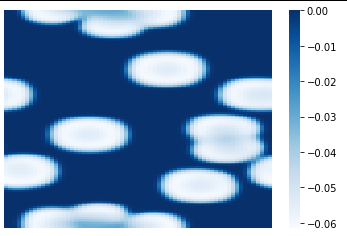
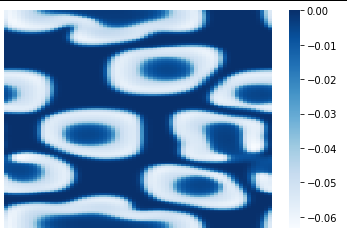
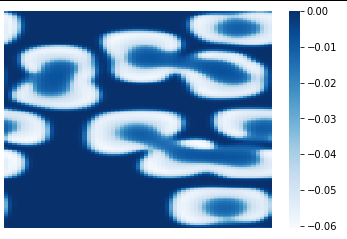

Note: you might need to experiment with the initial conditions for *S* and *A*:<br> 
 - Choose values between 2 and 5.<br>
 - add different noise levels, like e.g.<br>

In [ ]:
A[:,:,0] = 0.01*np.random.rand(D.Lx, D.Ly)
S[:,:,0] += 0.01*np.random.rand(D.Lx, D.Ly)
Y[:,:,0] = 0.01*np.random.rand(D.Lx, D.Ly)

How do the pattern change?

_Type your answer here, replacing this text._

In [ ]:
class FurPattern():

    def __init__(self):
        ...
        
        
    def RunSimulation(self, N: int = 10):
        ...

In [ ]:
F = FurPattern()
F.RunSimulation()

<!-- END QUESTION -->



## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

Submit only the PDF to Gradescope! Do not submit the zip or ipynb files.

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export()